## DSTRF

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import numpy as np
import cv2
from PIL import Image
import yaml

from scipy.signal import resample, chirp
from sklearn.linear_model import Ridge, ElasticNet

import naplib as nl
from naplib.visualization import strf_plot
import pickle as pkl

In [2]:
import dynamic_strf as dstrf

In [3]:
import IPython.display as ipd
#from hdf5storage import loadmat

import torch
import torchaudio
import pytorch_lightning as plc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
torch.set_float32_matmul_precision("medium")
print(device)

cuda


In [4]:
with open('prep_response.npy', 'rb') as f:
    small_response = np.load(f)
with open('prep_spec.npy', 'rb') as f:
    spec = np.load(f)

with open("code_params.yaml", "r") as file:
    code_params = yaml.load(file, yaml.Loader)

In [5]:
# define builder and trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pl_bolts.callbacks.printing import PrintTableMetricsCallback

tb_logger = TensorBoardLogger(
    f"{code_params['output_prefix']}/logs", name=f"{code_params['output_prefix'].replace("output/", "")}", log_graph=False
)


def trainer():
    return plc.Trainer(
        accelerator="auto",
        precision="16-mixed",
        gradient_clip_val=10.0,
        max_epochs=code_params["max_epochs"],
        logger=tb_logger,
        log_every_n_steps=1,
        detect_anomaly=False,
        enable_model_summary=False,
        enable_progress_bar=True,
        enable_checkpointing=True,
        callbacks=[PrintTableMetricsCallback()],
    )


def builder():
    return dstrf.modeling.DeepEncoder(
        input_size=spec.shape[2],
        hidden_size=64,
        channels=small_response.shape[2],
    ).to(device)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(spec, small_response, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train), torch.from_numpy(y_test)
print(X_train.shape)
print(y_train.shape)

torch.Size([40, 15, 129])
torch.Size([40, 15, 25840])


In [7]:
import os, yaml, ipynbname

os.system(
    f"jupyter nbconvert --to script thesis.ipynb --output-dir {code_params['output_prefix']}"
)

if __name__ == '__main__':
    dstrf.modeling.fit_multiple(
        builder=builder,
        data=(X_train, y_train),
        batch_size=8,
        crossval=code_params["crossval"],
        jackknife=code_params['jackknife'],
        trainer=trainer,
        save_dir=f"{code_params['output_prefix']}/model",
        verbose=1,
    )

Directory "output/170x152/model" already exists.
Fitting model for leave out: []... Skip.


In [8]:
# import glob, os
# checkpoints = sorted(glob.glob(os.path.join('output/5x128-jackknife-cv', 'model-*.pt')))
# print(checkpoints)

In [9]:
raw_scores = dstrf.modeling.test_multiple(
    model=builder(),
    checkpoints=f"{code_params['output_prefix']}/model",
    data=(X_test, y_test),
    crossval=code_params["crossval"],
    jackknife_mode="score",
)
raw_scores.numpy()

array([[           nan, -1.4901161e-08, -1.4901161e-08, ...,
         2.9802322e-08, -5.5879354e-08,            nan],
       [           nan, -2.2351742e-08, -3.7252903e-09, ...,
        -2.9802322e-08, -7.4505806e-08,            nan],
       [           nan,  0.0000000e+00, -2.9802322e-08, ...,
         1.4901161e-08, -2.2351742e-08,            nan],
       ...,
       [           nan,  0.0000000e+00,  2.9802322e-08, ...,
         3.7252903e-09, -4.4703484e-08,            nan],
       [           nan, -2.2351742e-08, -2.9802322e-08, ...,
         1.4901161e-08,  7.4505806e-09,            nan],
       [           nan,  4.0978193e-08, -1.4901161e-08, ...,
        -4.4703484e-08,  2.2351742e-08,            nan]], dtype=float32)

0.9825687


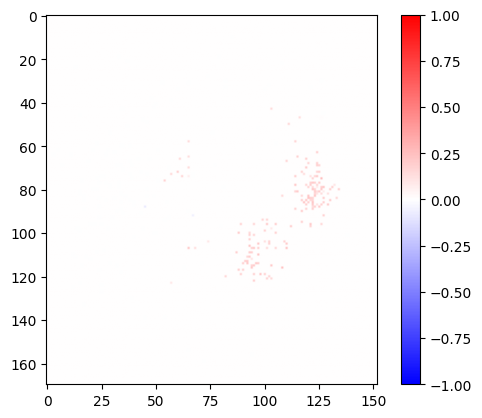

In [10]:
from sklearn.preprocessing import normalize
raw_scores = np.nan_to_num(raw_scores)
scores = normalize(raw_scores, axis=0)
print(np.max(scores))
scores = scores.reshape((-1, 170, 152))
scores = np.mean(scores, axis=0)
plt.imshow(scores, cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()

In [11]:
dstrf.estimate.dSTRF_multiple(
    model=builder(),
    checkpoints=f"{code_params['output_prefix']}/model",
    data=X_test[:1],
    crossval=code_params["crossval"],
    save_dir=f"{code_params['output_prefix']}/dstrf",
    chunk_size=1,
)

In [15]:
code_params['estimated_channels'] = [20, 400, 20000]
dstrf.visualize.dSTRF(
    f"{code_params['output_prefix']}/dstrf/dSTRF-001.pt",
    channels=code_params['estimated_channels'],
    time_range=slice(0, None, 1),
    output_prefix=f"{code_params['output_prefix']}",
    vcodec="libx264",
    xlabel="Time lag (ms)",
    xticks=[0, 65],
    xtick_labels=[-15, 0],
    ylabel="Frequency",
    yticks=[0, 64],
    ytick_labels=["20Hz", "60KHz"],
)

In [ ]:
ipd.display(
    ipd.Video(f"{code_params['output_prefix']}/video/channel-0000.mkv", height=300)
)